# Analyse des occupations   

In [1]:
### Librairies externes à ajouter le cas échéant à l'environnement Python actif

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import networkx as nx

### Librairies déjà installées avec Python

import pprint
import csv
import sys

from importlib import reload



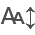

In [2]:
### Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)

In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## Importer les donnée à analyser

In [4]:
## define SPARQL enpoint
endpoint = "https://ag16gm9pr0meths2.allegrograph.cloud/repositories/astronomers"

In [5]:
### Get and count persons occupations

query = """PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?occupation ?occupationLabel (COUNT(*) as ?n)
WHERE {
    GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
        {?item wdt:P106 ?occupation.
        OPTIONAL {?occupation rdfs:label ?occupationLabel}    
          }
}
GROUP BY ?occupation ?occupationLabel 
ORDER BY DESC(?n)
#LIMIT 30
"""

In [6]:
### Execute the query using the local custom fonctions
qr = spqf.get_json_sparql_result(endpoint,query)

In [7]:
### Count and inspect the available occupations
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

966


[['http://www.wikidata.org/entity/Q169470', 'physicist', '18243'],
 ['http://www.wikidata.org/entity/Q1622272', 'university teacher', '5704'],
 ['http://www.wikidata.org/entity/Q11063', 'astronomer', '5084']]

In [8]:
### Transform the results into a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uri', 'label', 'effectif']
df_r['effectif'] = df_r.effectif.apply(lambda x : int(x))
df_r.head()

,uri,label,effectif
0,http://www.wikidata.org/entity/Q169470,physicist,18243
1,http://www.wikidata.org/entity/Q1622272,university teacher,5704
2,http://www.wikidata.org/entity/Q11063,astronomer,5084
3,http://www.wikidata.org/entity/Q170790,mathematician,1985
4,http://www.wikidata.org/entity/Q81096,engineer,873


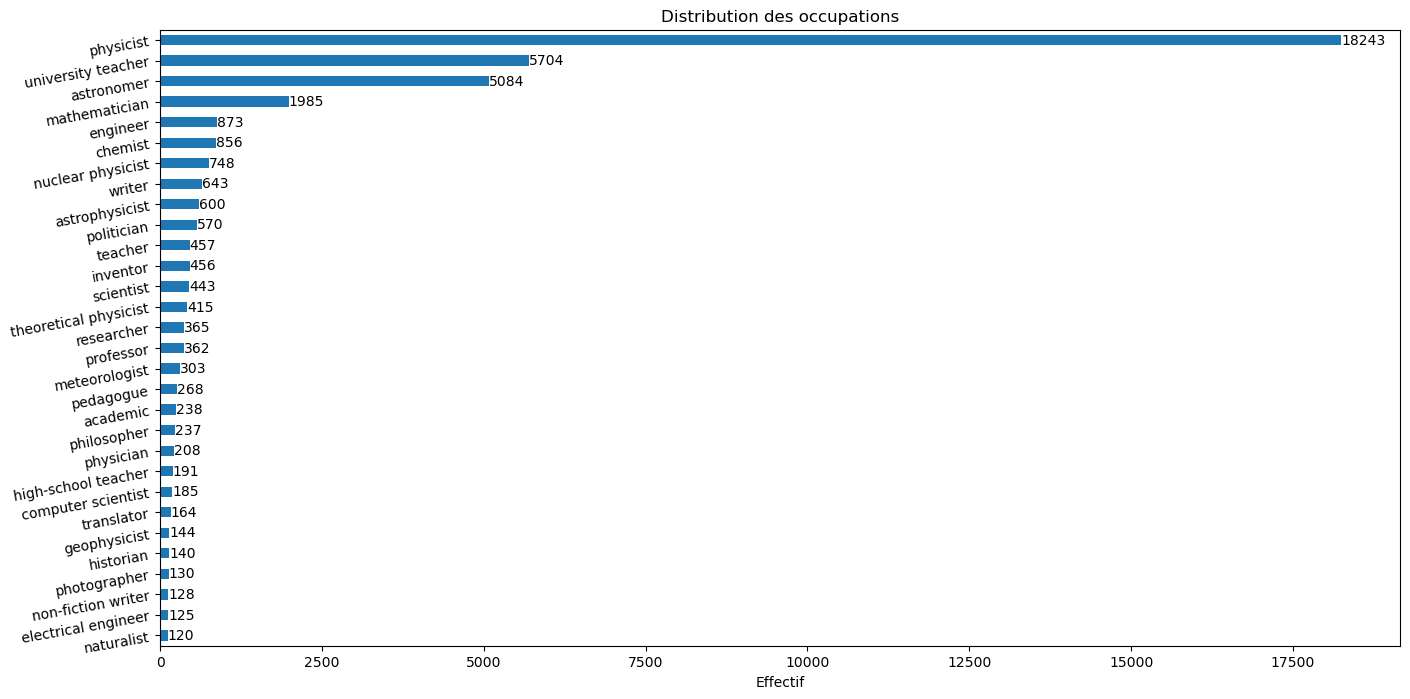

In [9]:
### Bar chart showing distribution by 'occupation': 
# 30 most frequent occupations
ax = df_r['effectif'].head(30).sort_values(ascending=True)\
    .plot(kind='barh',rot=10, fontsize=10, figsize=(16,8))
y_labels = reversed(df_r.head(30).label.to_list())
ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1])
plt.xlabel('Effectif')
plt.title('Distribution des occupations')
plt.show()

In [10]:
l= len(df_r[df_r['effectif'] == 1])
print(l)

443


In [11]:
l= len(df_r[df_r['effectif'] < 10])
print(l)

800


**Comment**: An extreme difference in distribution can be observed: four occupational categories are ten to thirty times larger than the others.

There are 443 occupations with only one person and 800 with less than 10 persons, for a total of 966 different occupations.

### Graphically represent the frequency distribution

There is a wide dispersion of values and a predominant position for activities involving 10 or fewer people

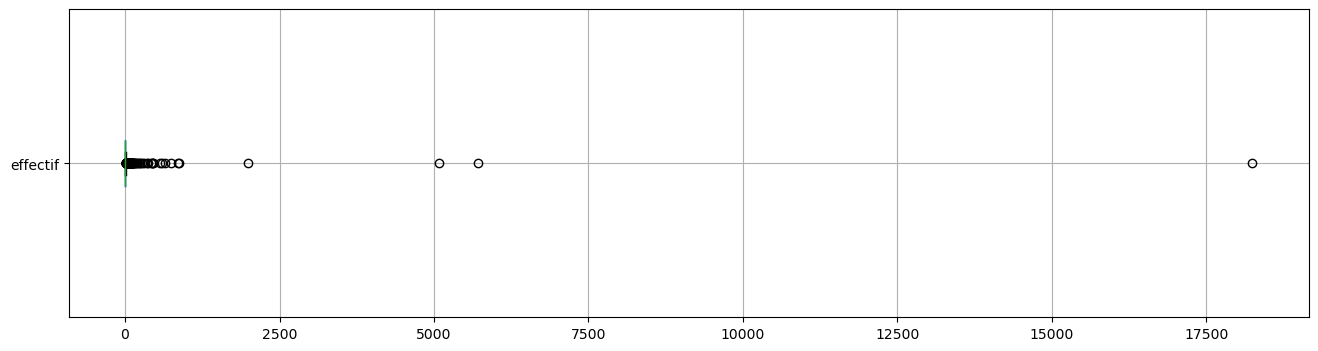

In [12]:
### Distribution des effectifs par occupation
ax = df_r.boxplot(column=['effectif'], vert=False, figsize=(16,4))

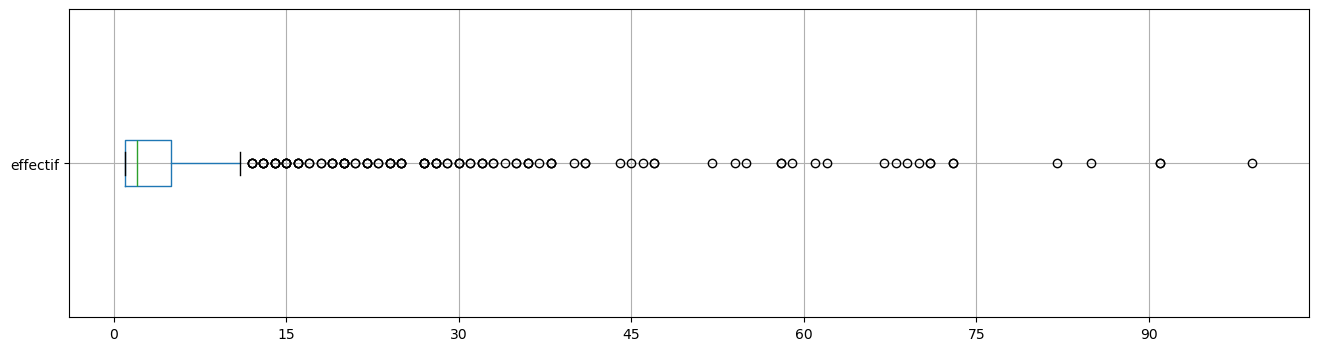

In [13]:
### Distribution des effectifs par occupation
ax = df_r[df_r.effectif<100].boxplot(column=['effectif'], vert=False, figsize=(16,4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

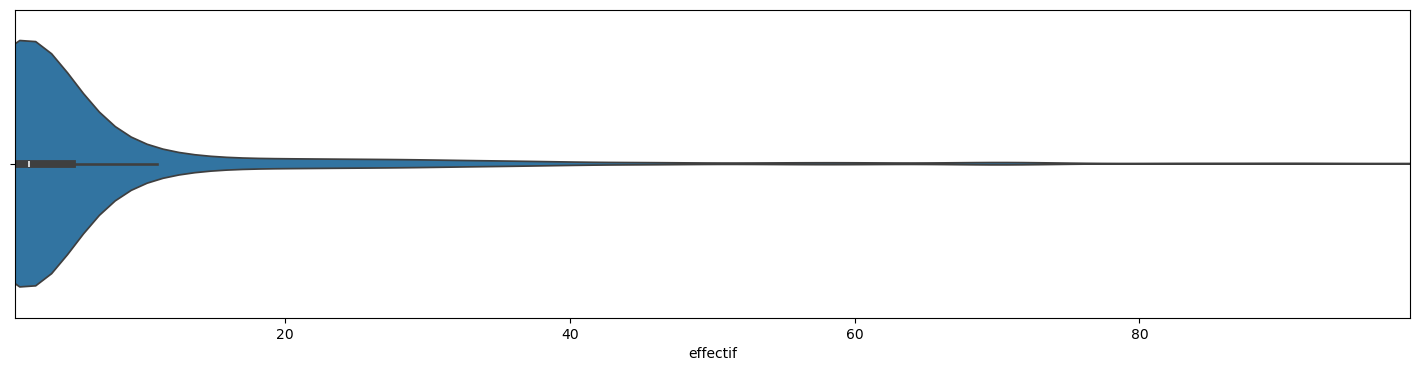

In [14]:
### Represent the density (the total surface has frequency = 1)
# https://seaborn.pydata.org/generated/seaborn.violinplot.html

plt.figure(figsize=(18,4))
d = df_r[df_r.effectif<100].effectif

ax = sns.violinplot(x = d)


### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=min(d), right=max(d))
plt.show()

### Group by frequency range

In [16]:
### Set the thresholds

ls = [1, 5, 10, 20, 50, 100, 200, 300, 500, 1000, 30000]
print(ls)

[1, 5, 10, 20, 50, 100, 200, 300, 500, 1000, 30000]


In [17]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_r['seuils'] = pd.cut(df_r['effectif'], ls, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_r['seuils'] = df_r['seuils'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_r.head(3)

,uri,label,effectif,seuils
0,http://www.wikidata.org/entity/Q169470,physicist,18243,1000-29999
1,http://www.wikidata.org/entity/Q1622272,university teacher,5704,1000-29999
2,http://www.wikidata.org/entity/Q11063,astronomer,5084,1000-29999


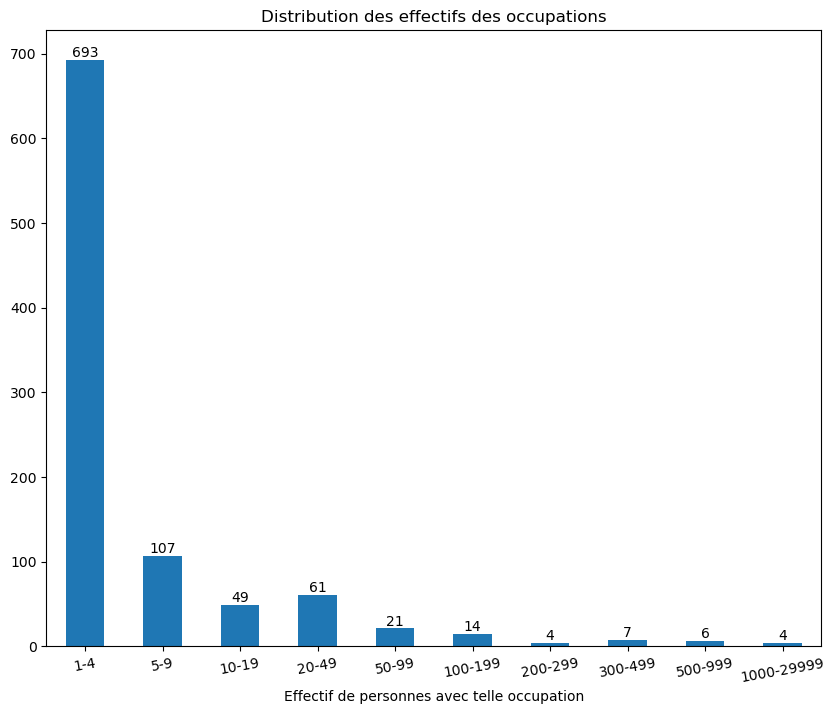

In [18]:
# Plot the grouped distribution

ax = df_r.groupby(by='seuils', observed=False).size()\
    .plot(kind='bar',rot=10, fontsize=10, figsize=(10,8))
ax.bar_label(ax.containers[-1], fontsize=10)
plt.xlabel('Effectif de personnes avec telle occupation')
plt.title('Distribution des effectifs des occupations')
plt.show()

### Inspect the values

In [19]:
print(df_r[df_r['effectif'] == 1].head(10).label)

523                     Go player
524    architectural draftsperson
525               Engelandvaarder
526            materials engineer
527                 chess teacher
528              general director
529                     waka poet
530                         hiker
531                        miller
532                      governor
Name: label, dtype: object


In [20]:
print(df_r[df_r['effectif'] == 5].head(10).label)

245                        scholar
246                  lexicographer
247         historian of astronomy
248                      presenter
249                  volcanologist
250                  psychoanalyst
251          atmospheric physicist
252                     watchmaker
253    association football player
254                   army officer
Name: label, dtype: object


In [21]:
print(df_r[df_r['effectif'] == 10].head(10).label)

158       particle physicist
159     athletics competitor
160            film director
161               topologist
162    information scientist
163                 merchant
164                ecologist
165      political scientist
Name: label, dtype: object


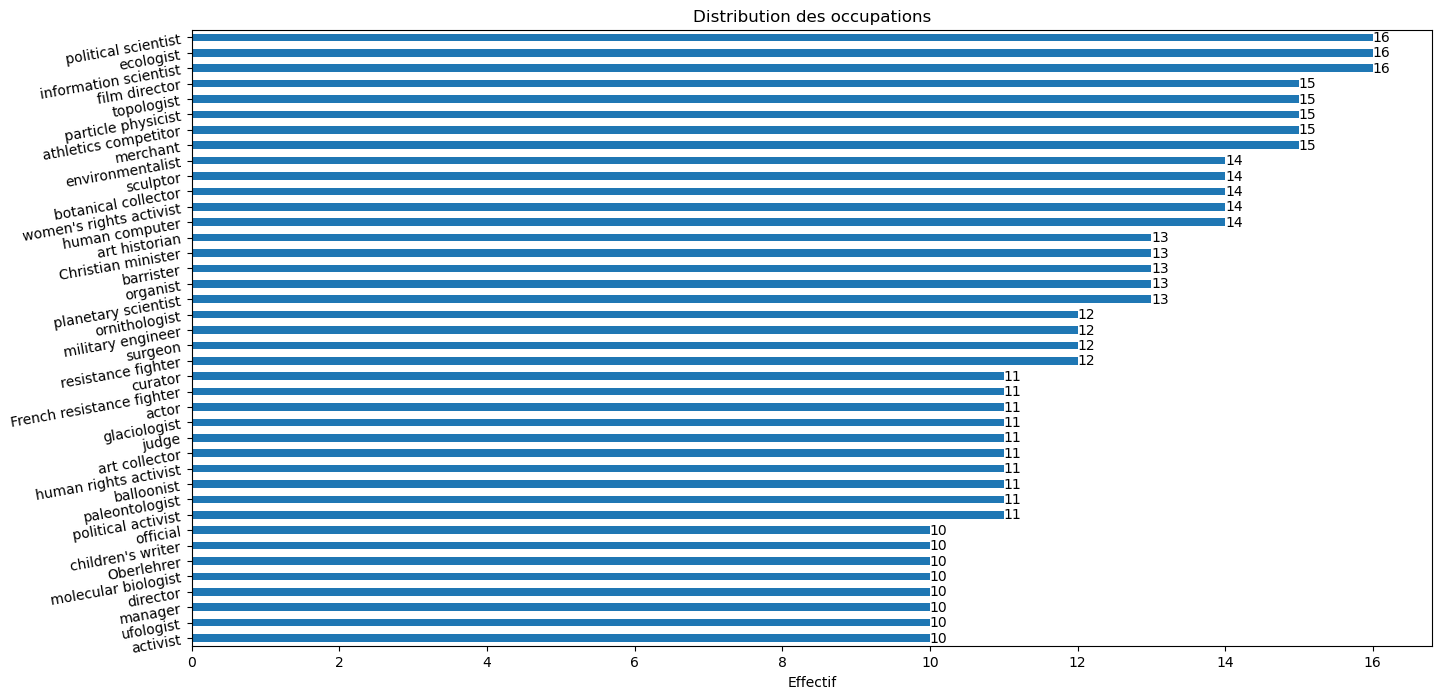

In [22]:
### Bar chart representing the distribution by ‘occupation’ 
# in a given frequency range

d = df_r[(df_r.effectif < 100)&(df_r.effectif > 9)].sort_values(by='effectif',ascending=True).head(40)
ax = d.effectif.plot(kind='barh',rot=10, fontsize=10, figsize=(16,8))
y_labels = reversed(d.label.to_list())
ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1])
plt.xlabel('Effectif')
plt.title('Distribution des occupations')
plt.show()

**Comment**

Observation of the typology of occupations reveals a variety that leads to two different types of questions: 
* the specificities of profiles within scientific disciplines
* other activities (artistic, economic, etc.) in their relationship with the disciplines


The aim will be to better define the question or questions we wish to address and to use the information available in Wikidata to create classes.


Another question we could raise is the *changing distribution and configuration over tim*e.

Another question we could ask is the changing distribution and configuration over time. To answer this question, we should add the birth years or generations of the individuals to the characteristics of the occupations.


## Explore the number of occupations per person

In [23]:
### Basic query regarding persons' occupations

query = """PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?item ?itemLabel (COUNT(*) as ?n)
WHERE {
    GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
        {?item wdt:P106 ?occupation.
        OPTIONAL {?item rdfs:label ?itemLabel}    
          }
}
GROUP BY ?item ?itemLabel
ORDER BY DESC(?n)
LIMIT 500
"""

In [24]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [25]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

500


[['http://www.wikidata.org/entity/Q6694', 'Alexander von Humboldt', '24'],
 ['http://www.wikidata.org/entity/Q470334', 'Euclides da Cunha', '16'],
 ['http://www.wikidata.org/entity/Q410', 'Carl Sagan', '16']]

In [26]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uri', 'label', 'effectif']
df_r['effectif'] = df_r.effectif.apply(lambda x : int(x))
df_r.head()

,uri,label,effectif
0,http://www.wikidata.org/entity/Q6694,Alexander von Humboldt,24
1,http://www.wikidata.org/entity/Q470334,Euclides da Cunha,16
2,http://www.wikidata.org/entity/Q410,Carl Sagan,16
3,http://www.wikidata.org/entity/Q5609050,Grigorie Sturdza,15
4,http://www.wikidata.org/entity/Q521729,Cheikh Anta Diop,15


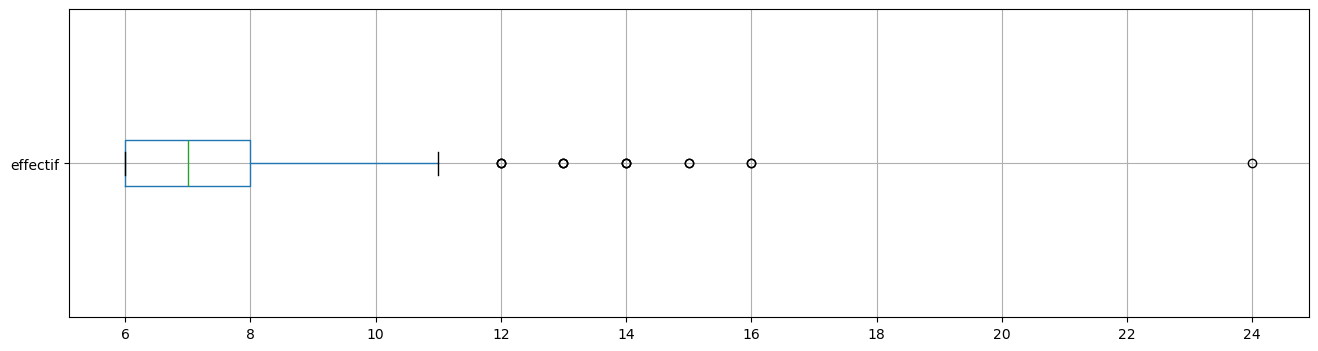

In [27]:
### Distribution of frequencies per person
ax = df_r.boxplot(column=['effectif'], vert=False, figsize=(16,4))

## this fuction avoids ticks with floats instead of integers
#  on the x axis
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

**Comment**

Most persons have between 6 and 8 occupations, with some outliers

77


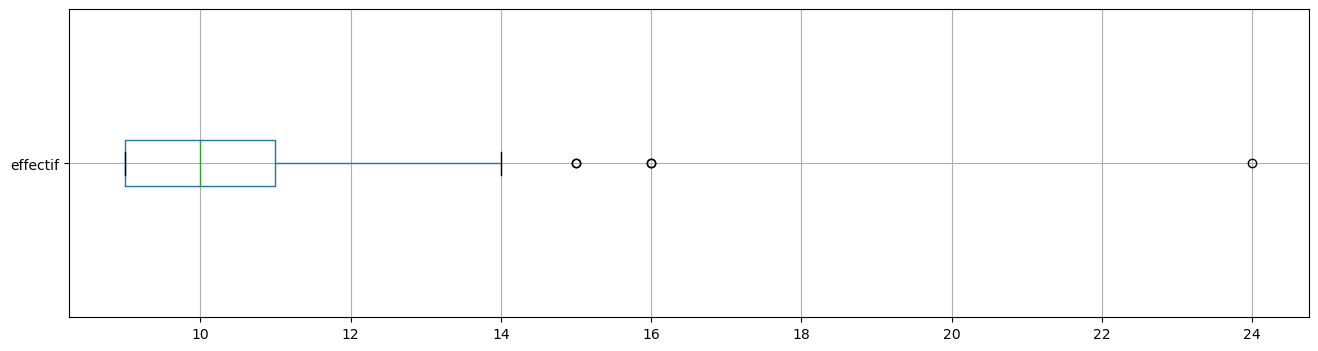

In [30]:
### Distribution des effectifs par occupation

d = df_r[df_r.effectif > 8]
print(len(d))

ax = d.boxplot(column=['effectif'], vert=False, figsize=(16,4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [31]:
### Cf. the profiles of these persons in Wikidata
pprint.pprint(d.tail())

                                        uri                   label  effectif
72   http://www.wikidata.org/entity/Q336769         Pavel Florensky         9
73   http://www.wikidata.org/entity/Q211551         Nikolay Morozov         9
74   http://www.wikidata.org/entity/Q372215       Walter Cunningham         9
75   http://www.wikidata.org/entity/Q187520  Charles Sanders Peirce         9
76  http://www.wikidata.org/entity/Q3129074          Heather Couper         9


## Parent occupations

In [33]:
query = """
## 

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>

SELECT ?parentOccupation ?parentOccupationLabel (COUNT(*) as ?n)
    
WHERE
    {
        GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
        ## Find the persons in the imported graph
        { ?item a wd:Q5;
             rdfs:label ?personLabel;
           wdt:P569 ?birthYear;
            wdt:P106 ?occupation.
            ?occupation   wdt:P279 ?parentOccupation;
                    rdfs:label ?occupationLabel.
            ?parentOccupation rdfs:label ?parentOccupationLabel.
        }
    }
GROUP BY ?parentOccupation ?parentOccupationLabel        
ORDER BY DESC(?n)
"""

In [34]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [35]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

636


[['http://www.wikidata.org/entity/Q124637774', 'physical scientist', '19156'],
 ['http://www.wikidata.org/entity/Q901', 'scientist', '7495'],
 ['http://www.wikidata.org/entity/Q37226', 'teacher', '6043']]

In [36]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uri', 'label', 'effectif']
df_r['effectif'] = df_r.effectif.apply(lambda x : int(x))
df_r.iloc[ 20:50 , ]

,uri,label,effectif
20,http://www.wikidata.org/entity/Q11424604,earth scientist,495
21,http://www.wikidata.org/entity/Q11448772,school staff,465
22,http://www.wikidata.org/entity/Q1622272,university teacher,440
23,http://www.wikidata.org/entity/Q18931911,theorist,439
24,http://www.wikidata.org/entity/Q864503,biologist,429
25,http://www.wikidata.org/entity/Q15980158,non-fiction writer,427
26,http://www.wikidata.org/entity/Q15319501,social scientist,384
27,http://www.wikidata.org/entity/Q1706722,research fellow,372
28,http://www.wikidata.org/entity/Q66666685,academic professional,371
29,http://www.wikidata.org/entity/Q17276189,atmospheric scientist,337


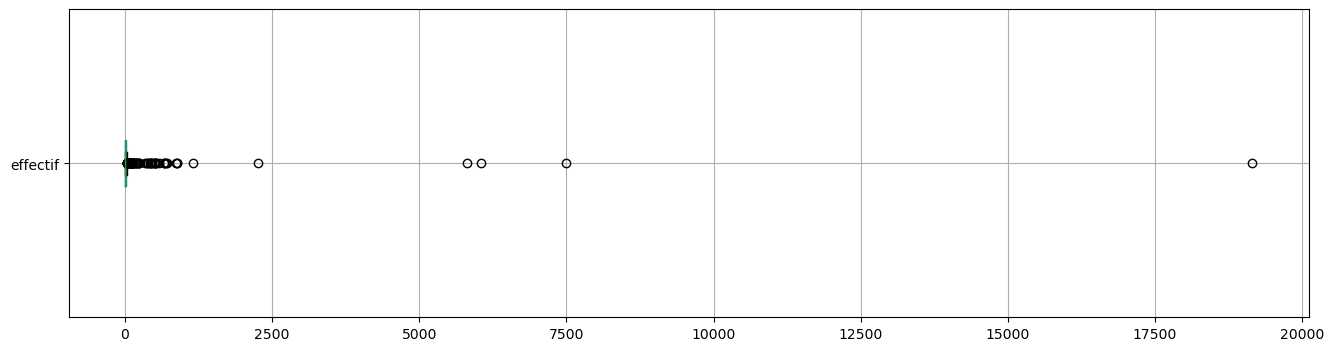

In [37]:
### Distribution of frequencies per person
ax = df_r.boxplot(column=['effectif'], vert=False, figsize=(16,4))

## this fuction avoids ticks with floats instead of integers
#  on the x axis
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

### Group by frequency range

In [40]:
### Set the thresholds

ls = [1, 5, 10, 20, 50, 100, 200, 300, 500, 1000, 30000]
print(ls)

[1, 5, 10, 20, 50, 100, 200, 300, 500, 1000, 30000]


In [41]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_r['seuils'] = pd.cut(df_r['effectif'], ls, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_r['seuils'] = df_r['seuils'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_r.head(3)

,uri,label,effectif,seuils
0,http://www.wikidata.org/entity/Q124637774,physical scientist,19156,1000-29999
1,http://www.wikidata.org/entity/Q901,scientist,7495,1000-29999
2,http://www.wikidata.org/entity/Q37226,teacher,6043,1000-29999


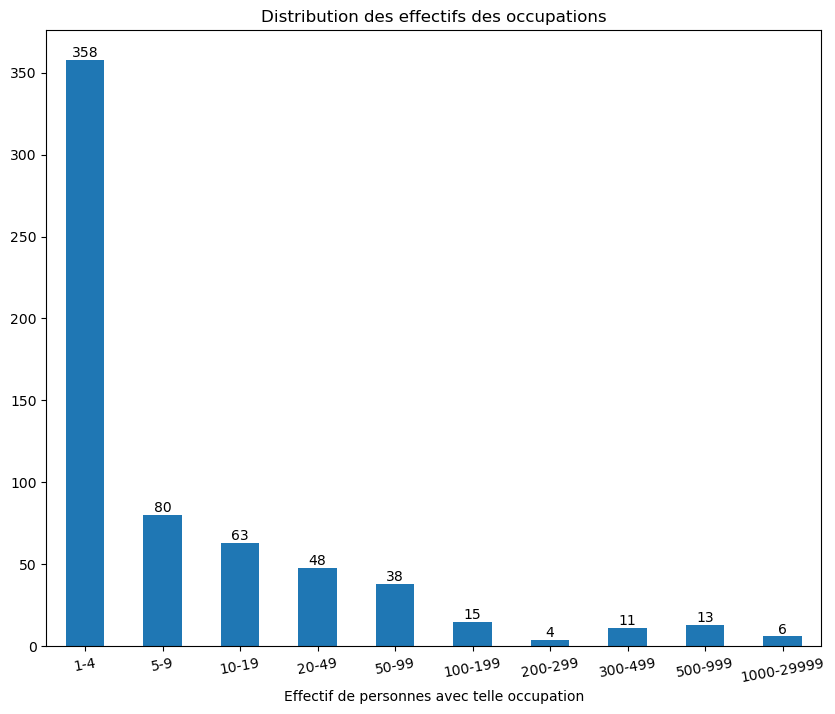

In [42]:
# Plot the grouped distribution

ax = df_r.groupby(by='seuils', observed=False).size()\
    .plot(kind='bar',rot=10, fontsize=10, figsize=(10,8))
ax.bar_label(ax.containers[-1], fontsize=10)
plt.xlabel('Effectif de personnes avec telle occupation')
plt.title('Distribution des effectifs des occupations')
plt.show()

## A faire : articuler / séparer la population entre astronomees et physiciens
Chois heuristique de base

In [50]:
query = """
### Occupation classifications

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?birthYear ?o ?oLabel ?o1 ?o1Label
WHERE {
    GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
        {?item a wd:Q5;
            wdt:P569 ?birthYear;
            wdt:P106 ?o.
        ?o a wd:Q12737077;
            wdt:P279 ?o1.
        OPTIONAL {?o rdfs:label ?oLabel}    
        OPTIONAL {?o1 rdfs:label ?o1Label}    
          }
}
ORDER BY ?s
"""

In [51]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [52]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

64429


[['1923',
  'http://www.wikidata.org/entity/Q169470',
  'physicist',
  'http://www.wikidata.org/entity/Q124637774',
  'physical scientist'],
 ['1908',
  'http://www.wikidata.org/entity/Q169470',
  'physicist',
  'http://www.wikidata.org/entity/Q124637774',
  'physical scientist'],
 ['1882',
  'http://www.wikidata.org/entity/Q3126128',
  'geneticist',
  'http://www.wikidata.org/entity/Q864503',
  'biologist']]

In [56]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['year', 'oc_uri', 'oc_label', 'op_uri', 'op_label']
df_r['year'] = df_r.year.apply(lambda x : int(x))
df_r.head()

,year,oc_uri,oc_label,op_uri,op_label
0,1923,http://www.wikidata.org/entity/Q169470,physicist,http://www.wikidata.org/entity/Q124637774,physical scientist
1,1908,http://www.wikidata.org/entity/Q169470,physicist,http://www.wikidata.org/entity/Q124637774,physical scientist
2,1882,http://www.wikidata.org/entity/Q3126128,geneticist,http://www.wikidata.org/entity/Q864503,biologist
3,1937,http://www.wikidata.org/entity/Q1650915,researcher,http://www.wikidata.org/entity/Q66666685,academic professional
4,1937,http://www.wikidata.org/entity/Q1650915,researcher,http://www.wikidata.org/entity/Q15980158,non-fiction writer


### Codage par période de cinquante ans

In [ ]:
### Créer une liste d'années pour séparer en périodes de 50 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
d = list(range(1751, 2001, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1751, 1776, 1801, 1826, 1851] [1851, 1876, 1901, 1926, 1951] 8


In [58]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_r['per_25'] = pd.cut(df_r['year'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_r['per_25'] = df_r['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_r.head(3)

,year,oc_uri,oc_label,op_uri,op_label,per_25
0,1923,http://www.wikidata.org/entity/Q169470,physicist,http://www.wikidata.org/entity/Q124637774,physical scientist,1901-1925
1,1908,http://www.wikidata.org/entity/Q169470,physicist,http://www.wikidata.org/entity/Q124637774,physical scientist,1901-1925
2,1882,http://www.wikidata.org/entity/Q3126128,geneticist,http://www.wikidata.org/entity/Q864503,biologist,1876-1900


In [ ]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25').size()
print(naissances_per)

per_25
1751-1775     254
1776-1800     326
1801-1825     532
1826-1850     809
1851-1875    1312
1876-1900    1916
1901-1925    4210
1926-1950    8132
dtype: int64


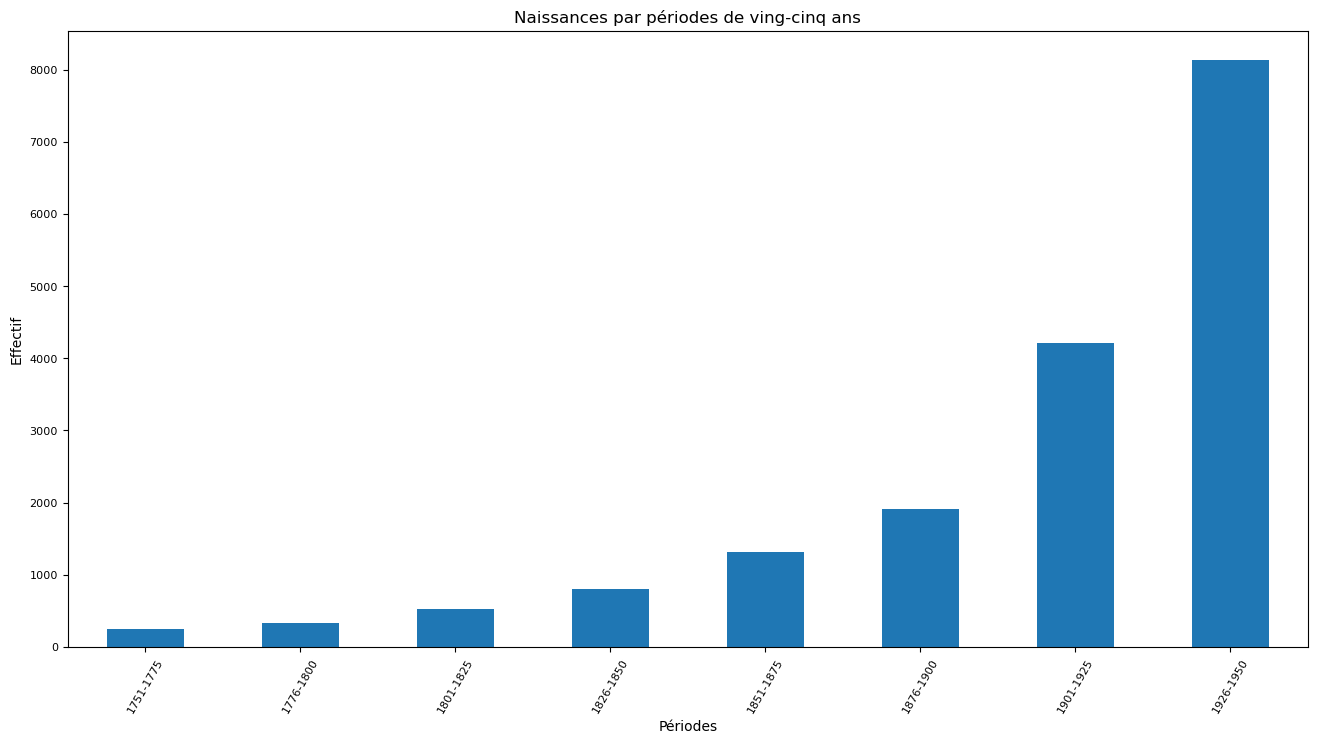

In [ ]:
### Diagramme à barres représentant la distribution par 'génération'
ax = df_p.groupby(by='per_25').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de ving-cinq ans')
plt.show()

In [70]:
### distribution des naissances par périodes de 25 ans
gb_oc = df_r.groupby(by=['oc_label','op_label'], observed=False, as_index=False).size()
print(len(gb_oc))
gb_oc.head()

1462


,oc_label,op_label,size
0,Aliyah Bet activist,political activist,2
1,Anglican priest,Anglican clergyman,4
2,Anglican priest,Western priest,4
3,Bible translator,biblical scholar,2
4,Bible translator,translator,2


In [72]:

## [gb_oc['size'] > 4 ]

show(gb_oc.sort_values(by='size', ascending=False),  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

Loading... (need help?)


# La suite est en préparation

## Paires d'occupations

In [ ]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>

## Pour avoir les données avec la personne et l'effectif de toutes les relations
# SELECT DISTINCT ?item ?occupation ?occupationLabel ?occupation_1 ?occupation_1Label

SELECT ?occupation ?occupationLabel ?occupation_1 ?occupation_1Label
WHERE
  {GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
     {
      ?item wdt:P106 ?occupation.
      ?item wdt:P106 ?occupation_1.
      ?occupation rdfs:label ?occupationLabel.
      ?occupation_1 rdfs:label ?occupation_1Label.
      FILTER (str(?occupationLabel) < str(?occupation_1Label))
      } 

      }
"""

In [ ]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [ ]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

In [ ]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uri', 'label', 'uri_1', 'label1_']
df_r.uri = df_r.uri.apply(lambda x : x.replace('http://www.wikidata.org/entity/', ''))
df_r.uri_1 = df_r.uri_1.apply(lambda x : x.replace('http://www.wikidata.org/entity/', ''))
df_r.head()

In [ ]:
list(df_r.columns)

In [ ]:
gr = pd.DataFrame(df_r.groupby(['uri', 'label', 'uri_1', 'label1_']).size())
gr.reset_index(inplace=True)
gr.columns=list(df_r.columns)+['size']
gr.sort_values(by='size', ascending=False).head(40)

In [ ]:
gr.sort_values(by='size', ascending=False).tail(40)

In [ ]:
### Distribution des effectifs par occupation
ax = gr.boxplot(column=['size'], vert=False, figsize=(16,4))

In [ ]:
### Distribution des effectifs par occupation
ax = gr[(gr['size']>10) & (gr['size']<500)].boxplot(column=['size'], vert=False, figsize=(16,4))

In [ ]:
ax = gr['size'].plot(kind='bar',rot=10, fontsize=10, figsize=(10,8))
ax.bar_label(ax.containers[-1], fontsize=10)
plt.xlabel('Effectif de personnes avec telle occupation')
plt.title('Distribution des effectifs des occupations')
plt.show()

In [ ]:
plt.figure(figsize=(15, 4))
d = gr[(gr['size'] > 0) & (gr['size'] < 10)]['size']
#d = gr['size']


ax = sns.barplot(x = d)
ax.set_xlim(left=min(d), right=max(d))

ax.plot()

In [ ]:
show(gr[gr['size'] > 4 ].sort_values(by='size', ascending=False),  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

## Graphe

In [ ]:


l = []
for i in gr[gr['size'] > 10 ]:
    l.append(tuple((i['uri'],i['uri_1'])))
l[:5]



### A faire

* ajouter ITable pour exploration
* regrouper par type de valeurs
*
* 